<a href="https://colab.research.google.com/github/linhnguyen222/DPS-Silo/blob/master/Luna_SequenceTagMulticlass_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Multi-class Sequence Tagging for sentence classification

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec 11 15:25:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip -q install trax==1.3.1

import trax 
from trax import layers as tl
import os 
import numpy as np
import pandas as pd
from pathlib import Path


#from pytorch_pretrained_bert import BertTokenizer
import torch
from pandas import DataFrame
import random as rnd

# set random seeds to make this notebook easier to replicate
trax.supervised.trainer_lib.init_random_number_generators(33)

     |████████████████████████████████| 348kB 14.5MB/s 
     |████████████████████████████████| 1.5MB 22.8MB/s 
     |████████████████████████████████| 174kB 67.5MB/s 
     |████████████████████████████████| 2.6MB 66.6MB/s 
     |████████████████████████████████| 358kB 54.5MB/s 
     |████████████████████████████████| 5.3MB 61.6MB/s 
     |████████████████████████████████| 194kB 62.7MB/s 
     |████████████████████████████████| 368kB 56.4MB/s 
     |████████████████████████████████| 983kB 55.0MB/s 
     |████████████████████████████████| 348kB 56.0MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 655kB 52.3MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 1.4MB 55.2MB/s 
     |████████████████████████████████| 1.1MB 52.0MB/s 
     |████████████████████████████████| 3.7MB 45.8MB/s 
     |████████████████████████████████| 245kB 62.2MB/s 
     |████████████████████████████████| 51kB 7.4MB

DeviceArray([ 0, 33], dtype=uint32)

In [4]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
traindirectory = '/content/drive/My Drive/DSP/data/protechn_corpus_eval/train'
testdirectory = '/content/drive/My Drive/DSP/data/protechn_corpus_eval/test'


Mounted at /content/drive


In [5]:
def read_data(directory):
    ids = []
    texts = []
    labels = []
    for f in directory.glob('*.txt'):
        id = f.name.replace('article', '').replace('.txt','')
        ids.append(id)
        texts.append(f.read_text())
        labels.append(parse_label(f.as_posix().replace('.txt', '.labels.tsv')))
    # labels can be empty 
    return ids, texts, labels

def clean_text(articles, ids):
    texts = []
    for article, id in zip(articles, ids):
        sentences = article.split('\n')
        start = 0
        end = -1
        res = []
        for sentence in sentences:
           start = end + 1
           end = start + len(sentence)  # length of sequence 
           if sentence != "": # if not empty line
               res.append([id, sentence, start, end])
        texts.append(res)
    return texts


def make_dataset(directory):
    ids, texts, labels = read_data(directory)
    texts = clean_text(texts, ids)
    res = []
    for text, label in zip(texts, labels):
        # making positive examples
        tmp = [] 
        pos_ind = [0] * len(text)
        for l in label:
            for i, sen in enumerate(text):
                if l[0] >= sen[2] and l[0] < sen[3] and l[1] > sen[3]:
                    l[4] = 1
                    tmp.append(sen + [l[0], sen[3], l[2], l[3], l[4]])
                    pos_ind[i] = 1
                    l[0] = sen[3] + 1
                elif l[0] != l[1] and l[0] >= sen[2] and l[0] < sen[3] and l[1] <= sen[3]: 
                    tmp.append(sen + l)
                    pos_ind[i] = 1
        # making negative examples
        dummy = [0, 0, 'O', 0, 0]
        for k, sen in enumerate(text):
            if pos_ind[k] != 1:
                tmp.append(sen+dummy)
        res.append(tmp)     
    return res

In [6]:
def parse_label(label_path):
    labels = []
    f= Path(label_path)
    
    if not f.exists():
        return labels

    for line in open(label_path):
        parts = line.strip().split('\t')
        labels.append([int(parts[2]), int(parts[3]), parts[1], 0, 0])
    labels = sorted(labels) 

    if labels:
        length = max([label[1] for label in labels]) 
        visit = np.zeros(length)
        res = []
        for label in labels:
            if sum(visit[label[0]:label[1]]):
                label[3] = 1
            else:
               visit[label[0]:label[1]] = 1
            res.append(label)
        return res 
    else:
        return labels

In [7]:
#train set
dataset=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/train'))



####We form dataframe structure from the dataset read above and we name the columns.

In [8]:
#train dataframe
empty=[]
for i in dataset:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty.append(temp)

df=pd.concat(empty)  
df = df.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df.prop.value_counts()
df=df.reset_index()
#del df['index']

df.head()


,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop
0,0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism
1,1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism
2,2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification
3,3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation"
4,4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O


In [9]:
print("Size of train set is: ", df.shape[0])

Size of train set is:  15752


In [10]:
#we make the test set
dataset_test=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/test'))


In [11]:

#test dataframe
empty=[]
for i in dataset_test:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty.append(temp)

df_test=pd.concat(empty)  
df_test = df_test.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df_test.prop.value_counts()
df_test=df_test.reset_index()
#del df['index']

df_test.head()


,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop
0,0,111111133,"CNN in turn dropped its lawsuit on the matter,...",301,415,358,367,Loaded_Language
1,1,111111133,But while it yielded to Mr. Acosta — whose tes...,417,673,460,465,Loaded_Language
2,2,111111133,But while it yielded to Mr. Acosta — whose tes...,417,673,504,507,Loaded_Language
3,3,111111133,The White House sought to blame Mr. Acosta for...,967,1167,1070,1077,Loaded_Language
4,4,111111133,Codifying the behavior of journalists struck s...,1168,1391,1224,1244,Loaded_Language


In [12]:
print("Size of test set is: ", df_test.shape[0])

Size of test set is:  4490


In [13]:
"""
#Check the index
df=df.reset_index()
df.drop(['index'], axis=1)

print(df.iloc[15750:15760])"""

"\n#Check the index\ndf=df.reset_index()\ndf.drop(['index'], axis=1)\n\nprint(df.iloc[15750:15760])"


####Defining a new column (called 'label') to turn string labels into integer labels by using a defined label dictionary that maps each propaganda technique to an integer representing that class.

In [17]:
#We code the labels to integers
"""
possible_labels=df.prop.unique()
label_dict={}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label]=index
print(label_dict)
"""
label_dict={'O': 0, 'Black-and-White_Fallacy': 1, 'Loaded_Language': 2, 'Flag-Waving': 3, 
 'Name_Calling,Labeling': 4, 'Slogans': 5, 'Causal_Oversimplification': 6, 'Whataboutism': 7,
 'Exaggeration,Minimisation': 8, 'Doubt': 9, 'Appeal_to_Authority': 10, 'Repetition': 11, 'Appeal_to_fear-prejudice': 12,
 'Thought-terminating_Cliches': 13, 'Bandwagon': 14, 'Red_Herring': 15, 'Reductio_ad_hitlerum': 16,
 'Obfuscation,Intentional_Vagueness,Confusion': 17, 'Straw_Men': 18}

label_dict
#For both test and train set
df['label']=df.prop.replace(label_dict)
df_test['label']=df_test.prop.replace(label_dict)


In [18]:
df.head()

,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop,binary,sentence_length,prop_length,label
0,0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism,10,178,41,7
1,1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism,10,72,51,7
2,2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification,10,142,76,6
3,3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation",10,109,57,8
4,4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O,10,59,0,0


In [19]:
df.shape[0]

15752

####Adding a new column (called 'binary') for propaganda vs. non propaganda sentences. 

In [20]:
df['binary']=10
#test
#df.at[1,'binary']=10
for i in range (0, df.shape[0]):
    if df.iloc[i]['label']==0  :
        
        df.at[i, 'binary']= 0 
    else:
        #False
        df.at[i, 'binary']= 1 


For the purpose of  exploratory data analysis, and since we have the start and ending indice of full sentences as well as propaganda token, we can drive the length of sentences and propaganda tokens in two new columns ('sentence_length' and 'prop_length').

In [21]:
#we find length of sentence strings
df['sentence_length']=0
for i in range (0, df.shape[0]):
    df.at[i,'sentence_length']=df.iloc[i]['end_sent']-df.iloc[i]['start_sent'] 
        
        
 #we find length of propaganda token strings  
df['prop_length']=0
for i in range (0, df.shape[0]):
    df.at[i,'prop_length']=df.iloc[i]['end_prop']-df.iloc[i]['start_prop'] 
        

In [22]:
#df=pd.read_csv(Path("/content/export-train-seq"))
df.head()


,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop,binary,sentence_length,prop_length,label
0,0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism,1,178,41,7
1,1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism,1,72,51,7
2,2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification,1,142,76,6
3,3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation",1,109,57,8
4,4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O,0,59,0,0


In [23]:
df_test.head()

,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop,label
0,0,111111133,"CNN in turn dropped its lawsuit on the matter,...",301,415,358,367,Loaded_Language,2
1,1,111111133,But while it yielded to Mr. Acosta — whose tes...,417,673,460,465,Loaded_Language,2
2,2,111111133,But while it yielded to Mr. Acosta — whose tes...,417,673,504,507,Loaded_Language,2
3,3,111111133,The White House sought to blame Mr. Acosta for...,967,1167,1070,1077,Loaded_Language,2
4,4,111111133,Codifying the behavior of journalists struck s...,1168,1391,1224,1244,Loaded_Language,2


####For the purpose of sequence tagging a subset dataframe is formed from those sentences which hold a propaganda technique

In [24]:
%matplotlib notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


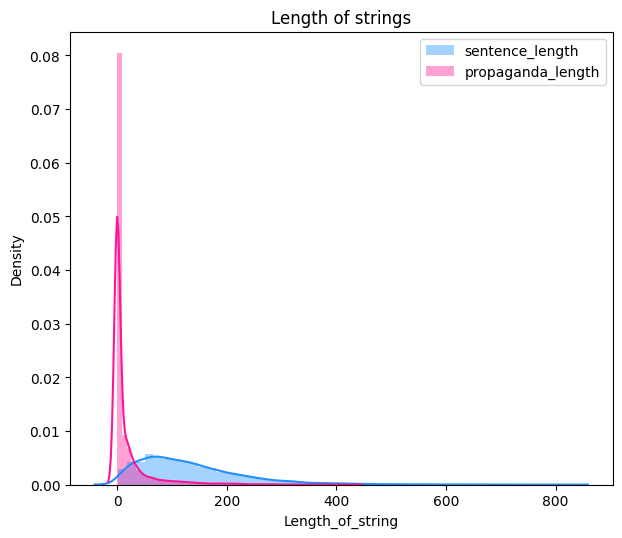

In [29]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(7,6), dpi=100)
sns.distplot( df['sentence_length'] , color="dodgerblue", label="sentence_length")
#sns.distplot( df.loc[df.species=='virginica', "sepal_length"] , color="orange", label="virginica")
#sns.distplot( df.loc[df.species=='versicolor', "sepal_length"] , color="deeppink", label="versicolor")
sns.distplot( df['prop_length'] , color="deeppink",  label="propaganda_length")

plt.gca().set(title='Length of strings', xlabel='Length_of_string')

#plt.title('Length of strings', xlabel='length')
plt.legend();
plt.show();      
        

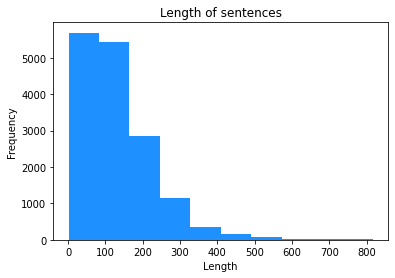

In [31]:

plt.hist(df['sentence_length'], color="dodgerblue", label="sentence_length")
plt.gca().set(title='Length of sentences', xlabel='Length', ylabel='Frequency')

#plt.title('Length of sentences')
plt.show()

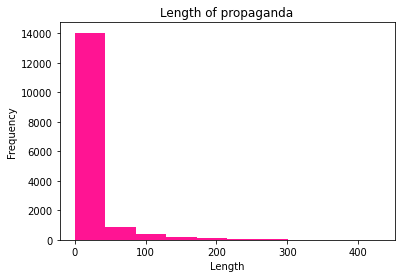

In [ ]:

plt.hist(df['prop_length'], color="deeppink")
plt.gca().set(title='Length of propaganda', xlabel='Length', ylabel='Frequency')
#plt.title('Length of propaganda')
plt.show()


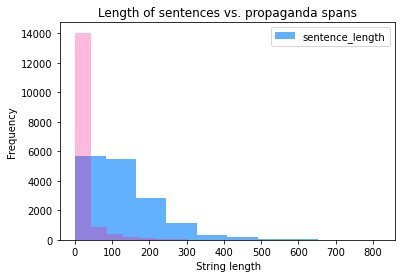

In [58]:

plt.hist(df['sentence_length'], color="dodgerblue", label="sentence_length",alpha=0.7)

plt.hist(df['prop_length'], color="deeppink", alpha=0.3)
plt.legend()

plt.gca().set(title='Length of sentences vs. propaganda spans', xlabel=' String length', ylabel='Frequency')
#plt.title('Length of sentences vs. propaganda spans')
plt.show()

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Attributes', 'Measures [string length]']
table.add_row(['Max of sentence length', df['sentence_length'].max()])
table.add_row(['Min of sentence length', df['sentence_length'].min()])
table.add_row(['Mean of sentence length', df['sentence_length'].mean()])
table.add_row([' ', ' '])
table.add_row(['Max of propaganda length', df['prop_length'].max()])
table.add_row(['Min of propaganda length', df['prop_length'].min()])
table.add_row(['Mean of propaganda length', df['prop_length'].mean()])

print(table)

+---------------------------+--------------------------+
|         Attributes        | Measures [string length] |
+---------------------------+--------------------------+
|   Max of sentence length  |           817            |
|   Min of sentence length  |            1             |
|  Mean of sentence length  |    131.66404266124937    |
|                           |                          |
|  Max of propaganda length |           430            |
|  Min of propaganda length |            0             |
| Mean of propaganda length |    15.778821736922296    |
+---------------------------+--------------------------+


###Preprocessing: tokenizing, cleaning and nemricalizing.

In [ ]:
    
import re 
"""
def clean(test):
    
     return re.sub(r'''
               [0123456789,.;“”*:-`/"%@#–?!~|&_$()]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               ''',
               ' ',          # and replace it with a single space
               test, flags=re.VERBOSE).replace('[',' ').replace(']',' ').replace('“', ' ').replace('-', ' ').replace("'", ' ') 

       """    
            

'\ndef clean(test):\n\n return re.sub(r\'\'\'\n           [0123456789,.;“”*:-`/"%@#–?!~|&_$()]+  # Accept one or more copies of punctuation\n           \\ *           # plus zero or more copies of a space,\n           \'\'\',\n           \' \',          # and replace it with a single space\n           test, flags=re.VERBOSE).replace(\'[\',\' \').replace(\']\',\' \').replace(\'“\', \' \').replace(\'-\', \' \').replace("\'", \' \') \n\n   '

In [ ]:
def clean(test_str):
  # initializing punctuations string  
  punc = '''!()-[]{};:`“”'"\|,+=<>./?@#$%^&*_~'''
  
# Removing punctuations in string 
# Using loop + punctuation string 
  for ele in test_str:  
    if ele in punc:  
        test_str = test_str.replace(ele, " ")  

  return test_str

In [ ]:
#example of cleaning text
a="this']'=,“i`|-+s? 100%notw“orking 'I am .tired!` )([])]I*/+:;-like_fruit...and milk'"

In [ ]:
#we apply clean function
b=clean(a)
print(b)

this      i    s  100 notw orking  I am  tired         I      like fruit   and milk 


###In this part a function for tagging is defined such that  words that are  parts of the string of a certain propaganda technique  are tagged as that technique and the rest of words in that sentence are tagged as none. 

In [ ]:
def label_a_sequence(only_prop_df):  
  all_tagged=[]
  """Pad token is 12121"""

  for i in range (0, len(only_prop_df)):
      #number of training example in one tsv file-length of each tsv dataframe
      #length= list_data[i].shape[0]
      #temp= nltk.sent_tokenize(s1[i])
          
      sentstart= only_prop_df.iloc[i][3]
      sentend= only_prop_df.iloc[i][4]
      propstart= only_prop_df.iloc[i][5]
      propend= only_prop_df.iloc[i][6]
      #label
      propclass=only_prop_df.iloc[i][8]
      count=0
      if propstart !=sentstart:
          #begin=df.iloc[i][4]
          #end=df.iloc[i][5]
          if propend !=sentend:
              begin= propstart-sentstart
              #proplength=propend_propstart   this is the length of the propaganda token
              end=propend-propstart+begin
              #beginstring.append(only_prop_df.iloc[i][2][:begin])
              length1=len(clean(only_prop_df.iloc[i][2][:begin]).split())
              begintag=[0]*length1
              
              #this is the substring that should be tagged
              length2=len(clean(only_prop_df.iloc[i][2][begin:end]).split())
              #midstring.append(clean(only_prop_df.iloc[i][2][begin:end]).split()
              midtag=[propclass]*length2

              
              length3=len(clean(only_prop_df.iloc[i][2][end:]).split())
              endtag=[0]*length3
              
              all_tagged.append(begintag+midtag+endtag)
                    
          else:
              
              begin= propstart-sentstart
              #proplength=propend_propstart   this is the length of the propaganda token
              #end=propend-propstart+begin
              length1=len(clean(only_prop_df.iloc[i][2][:begin]).split())
              begintag=[0]*length1
              # this is what should be tagged
              midstring=[]  
              length2=len(clean(only_prop_df.iloc[i][2][begin:]).split())
              midtag=[propclass]*length2
              
              all_tagged.append(begintag+midtag)

              
      else:
          
          if  propend !=sentend:
              
                      
              #begin= propstart-sentstart
              begin=0
              #proplength=propend_propstart   this is the length of the propaganda token
              end=propend-propstart
              #this is the substring that should be tagged
              length1=len(clean(only_prop_df.iloc[i][2][:end]).split())
              begintag=[propclass]*length1
              
              length2=len(clean(only_prop_df.iloc[i][2][end:]).split())
              endtag=[0]*length2
              all_tagged.append(begintag+endtag)

          else:  
                        
              length= len(clean(only_prop_df.iloc[i][2]).split())
              tag=[propclass]*length
              all_tagged.append(tag)
  return all_tagged


          

In [ ]:
#we tag all sentences in train set
all_tagged=label_a_sequence(df)

In [ ]:
print("The first  sentence is: ", df.iloc[0]["full_sent"])
print("The first  sentence propaganda is: ", df.iloc[0]["prop"])
print("The first tagged sentence is: ", all_tagged[0])
print("The size of all taged sentences from training set is:", len(all_tagged))
assert len(all_tagged)==(len(df))

The first  sentence is:  “They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.
The first  sentence propaganda is:  Whataboutism
The first tagged sentence is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]
The size of all taged sentences from training set is: 15752


In [ ]:
#we tag all sentences in the test set
#repeat the same process for test set
all_tagged_test=label_a_sequence(df_test)


###The tag_map corresponds to one of the possible tags a word can have. The cell below highlights the  classes that will be predicting. 

In [ ]:
tag_map= {'0': 0, 'Black-and-White_Fallacy': 1, 'Loaded_Language': 2, 'Flag-Waving': 3,
  'Name_Calling,Labeling': 4, 'Slogans': 5, 'Causal_Oversimplification': 6, 'Whataboutism': 7, 'Exaggeration,Minimisation': 8,
  'Doubt': 9, 'Appeal_to_Authority': 10, 'Repetition': 11, 'Appeal_to_fear-prejudice': 12, 'Thought-terminating_Cliches': 13,
  'Bandwagon': 14, 'Red_Herring': 15, 'Reductio_ad_hitlerum': 16, 'Obfuscation,Intentional_Vagueness,Confusion': 17, 'Straw_Men': 18}
 
 
full_sent= df['full_sent'].tolist()
full_sent_test= df_test['full_sent'].tolist()

print("tag_map is: ", tag_map)
 

tag_map is:  {'0': 0, 'Black-and-White_Fallacy': 1, 'Loaded_Language': 2, 'Flag-Waving': 3, 'Name_Calling,Labeling': 4, 'Slogans': 5, 'Causal_Oversimplification': 6, 'Whataboutism': 7, 'Exaggeration,Minimisation': 8, 'Doubt': 9, 'Appeal_to_Authority': 10, 'Repetition': 11, 'Appeal_to_fear-prejudice': 12, 'Thought-terminating_Cliches': 13, 'Bandwagon': 14, 'Red_Herring': 15, 'Reductio_ad_hitlerum': 16, 'Obfuscation,Intentional_Vagueness,Confusion': 17, 'Straw_Men': 18}


In [ ]:
from string import punctuation


###Vocab_to_int is a dictionary that translates a word string to a unique number. Given a sentence,then it is possible to  represent it as an array of numbers translating with this dictionary.

###We will create an index mapping dictionary in such a way that the frequently occurring words are assigned lower indexes.  Counter method from Collections library is used for this purpose. 


In [ ]:
#we build up the vocabulary from texts of both train and test set
full_sent_test_and_train=full_sent+full_sent_test

In [ ]:
for i in range(0,len(full_sent_test_and_train)):
    
    
    full_sent_test_and_train[i]=full_sent_test_and_train[i].lower()
    full_sent_test_and_train[i]=clean(full_sent_test_and_train[i])
    
    
    
#with space
all_text2 = ' '.join([c for c in full_sent_test_and_train if c not in punctuation])
#without space
all_text2 = ''.join([c for c in all_text2 if c not in punctuation])    
 
all_text2 = all_text2.split('\n')
all_text2 = ' '.join(all_text2)
words2=all_text2.split()
from collections import Counter

counts = Counter(words2)
vocab = sorted(counts, key=counts.get, reverse=True)

#print(vocab)
vocab_to_int = {word2: ii for ii, word2 in enumerate(vocab, 1)}
#print(vocab_to_int)
print('vocab["at"]:', vocab_to_int["at"])


vocab["at"]: 24


In [ ]:
#(full_sent_test_and_train[1800]

In [ ]:
#later when testing on a new data set some words might be unique and not exist in our already set dictionary
vocab_to_int['UNK']=1220022

###Next we numericalize each sentence in the training set

In [ ]:
full_sent=full_sent_test_and_train[:15752]


In [ ]:
full_sent_split=[]
for i in range(0, len(df)):
    full_sent_split.append(full_sent[i].split())
    
full_sent_ints = [] 

for i in range(len(df)):     
    full_sent_ints.append([vocab_to_int[word] for word in full_sent_split[i]])
    

In [ ]:
print("The first numericalized sentence in the train set is: ", full_sent_ints[0])
print("Its tag is: ", all_tagged[0])
assert (len (all_tagged) == len (full_sent_ints))
assert (len (all_tagged[0]) == len (full_sent_ints[0]))



The first numericalized sentence in the train set is:  [27, 5428, 1, 129, 6, 90, 130, 2, 142, 11, 12, 358, 971, 102, 537, 115, 2803, 2, 3771, 288, 6, 20, 130, 30, 27, 427, 2477, 377, 158]
Its tag is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]


In [ ]:
#We apply the same procedure for test set
full_sent_test=full_sent_test_and_train[15752:]
full_sent_split_test=[]
for i in range(0, len(df_test)):
    full_sent_split_test.append(full_sent_test[i].split())
    
full_sent_ints_test = [] 

for i in range(len(df_test)):     
    full_sent_ints_test.append([vocab_to_int[word] for word in full_sent_split_test[i]])

In [ ]:
print("The first numericalized sentence in the test set is: ", full_sent_ints_test[0])
print("Its tag is: ", all_tagged_test[0])
assert (len (all_tagged_test) == len (full_sent_ints_test))
assert (len (all_tagged_test[0]) == len (full_sent_ints_test[0]))

The first numericalized sentence in the test set is:  [408, 6, 1061, 3688, 73, 758, 10, 1, 366, 42, 39, 19475, 86, 5, 2788, 3, 170, 8636, 6, 1, 38, 1271]
Its tag is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


####Now that the sentences are cleaned, tokenized and numericalized it is possible to count average number of words and add this to the intuition about exploratory data analysis of the training set.

In [ ]:
#SENTENCE VS. SEQUENCE
""" We find length of each inner list which correspnds to number of words in each sentence """
length_of_sentences=[]
for i in range (len (full_sent_ints)):
  length_of_sentences.append(len(full_sent_ints[i]))

""" We find length of each inner list which correspnds to number of words in each SEQUENCE """
length_of_sequence=[]
for i in range (len (all_tagged)):
  length_of_sequence.append(len(all_tagged[i])-all_tagged[i].count(0))

In [ ]:
from prettytable import PrettyTable
from statistics import mean 

table = PrettyTable()
table.field_names = ['Attributes', 'Measures [ Word Count]']
table.add_row(['Max number of words in a sentence', max(length_of_sentences)])
table.add_row(['Min number of words in a sentence', min(length_of_sentences)])
table.add_row(['Average number of words in a sentence', mean(length_of_sentences)])
table.add_row([' ', ' '])
table.add_row(['Max number of words in a propaganda sequence', max(length_of_sequence)])
table.add_row(['Min number of words in a propaganda sequence', min(length_of_sequence)])
table.add_row(['Average number of words in propaganda sequence', mean(length_of_sequence)])

print(table)

+------------------------------------------------+------------------------+
|                   Attributes                   | Measures [ Word Count] |
+------------------------------------------------+------------------------+
|       Max number of words in a sentence        |          129           |
|       Min number of words in a sentence        |           0            |
|     Average number of words in a sentence      |   22.248031995937023   |
|                                                |                        |
|  Max number of words in a propaganda sequence  |           81           |
|  Min number of words in a propaganda sequence  |           0            |
| Average number of words in propaganda sequence |   2.643854748603352    |
+------------------------------------------------+------------------------+


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


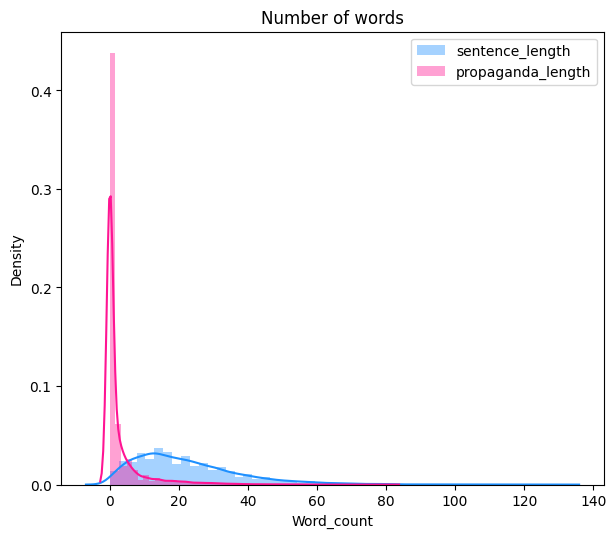

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(7,6), dpi=100)
sns.distplot( length_of_sentences , color="dodgerblue", label="sentence_length")
#sns.distplot( df.loc[df.species=='virginica', "sepal_length"] , color="orange", label="virginica")
#sns.distplot( df.loc[df.species=='versicolor', "sepal_length"] , color="deeppink", label="versicolor")
sns.distplot( length_of_sequence , color="deeppink",  label="propaganda_length")

#plt.title('Number of words')
plt.gca().set(title='Number of words', xlabel='Word_count')

plt.legend();
plt.show();      
        

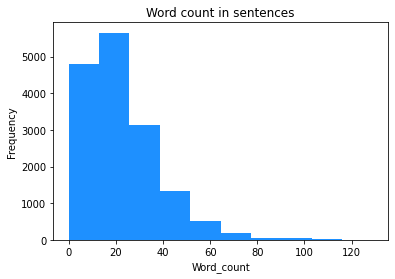

In [ ]:
import matplotlib.pyplot as plt
plt.hist(length_of_sentences, color="dodgerblue")
#plt.title('Word count in sentences')
plt.gca().set(title='Word count in sentences', xlabel='Word_count', ylabel='Frequency')

plt.show()

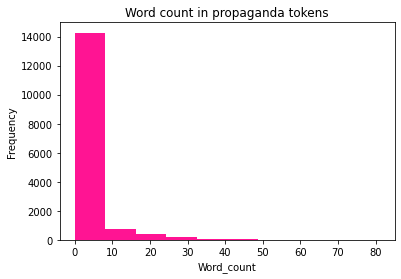

In [ ]:
import matplotlib.pyplot as plt
plt.hist(length_of_sequence, color="deeppink")
#plt.title('Word count in propaganda tokens')
plt.gca().set(title='Word count in propaganda tokens', xlabel='Word_count', ylabel='Frequency')

plt.show()

#### We now perform the same preprocess steps for test data set. 

In [ ]:
"""
empty_test=[]
for i in dataset_test:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty_test.append(temp)

df_test=pd.concat(empty_test)  
df_test= df_test.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df_test.prop.value_counts()
df_test=df_test.reset_index()
#del df_test['index']

df_test.head()

df_test['label']=df_test.prop.replace(label_dict)
df_test['binary']=10
#df_test.at[1,'binary']=11

for i in range (0, 4490):
    if (df_test.iloc[i]['label']==0 ) :
        
        df_test.at[i, 'binary']= 0 
    else:
        #False
        df_test.at[i, 'binary']= 1 
#df_test.head(15)"""

"\nempty_test=[]\nfor i in dataset_test:\n    \n    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])\n    empty_test.append(temp)\n\ndf_test=pd.concat(empty_test)  \ndf_test= df_test.drop(['ex1'],axis =1).drop(['ex2'],axis =1)\ndf_test.prop.value_counts()\ndf_test=df_test.reset_index()\n#del df_test['index']\n\ndf_test.head()\n\ndf_test['label']=df_test.prop.replace(label_dict)\ndf_test['binary']=10\n#df_test.at[1,'binary']=11\n\nfor i in range (0, 4490):\n    if (df_test.iloc[i]['label']==0 ) :\n        \n        df_test.at[i, 'binary']= 0 \n    else:\n        #False\n        df_test.at[i, 'binary']= 1 \n#df_test.head(15)"

In [ ]:
vocab=vocab_to_int
#we drive validation set as a small part of train set
tag_map=tag_map
#the first 12000 
t_sentences=full_sent_ints[:12000]
t_labels=all_tagged[:12000]
t_size=len(t_labels)
#from 12000 onwards
v_sentences=full_sent_ints[12000:]
v_labels=all_tagged[12000:]
v_size=len(v_labels)


#test set
test_sentences=full_sent_ints_test
test_labels=all_tagged_test
test_size=len(test_labels)



In [ ]:
print("the first sentence in train set is:", t_sentences[1])
print("its corresponding tagged label is: ", t_labels[1])
print("size of train set is: ", t_size)

the first sentence in train set is: [100, 3397, 10, 90, 4273, 96, 1, 159, 411, 4, 2133, 1572, 13, 1786]
its corresponding tagged label is:  [0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7]
size of train set is:  12000


In [ ]:
# Exploring information about the data
print('The number of outputs in tag_map is: ', len(tag_map))
# The number of vocabulary tokens (including <PAD>)
g_vocab_size = len(vocab)
print(f"Num of vocabulary words: {g_vocab_size}")
print('The vocab size is:', len(vocab))
print('The training size is: ', t_size)
print('The validation size is: ', v_size)
print('The test size is: ', test_size)

print('An example of the first sentence is: ', t_sentences[0])
print('An example of its corresponding label is: ', t_labels[0])

The number of outputs in tag_map is:  19
Num of vocabulary words: 20738
The vocab size is: 20738
The training size is:  12000
The validation size is:  3752
The test size is:  4490
An example of the first sentence is:  [27, 5428, 1, 129, 6, 90, 130, 2, 142, 11, 12, 358, 971, 102, 537, 115, 2803, 2, 3771, 288, 6, 20, 130, 30, 27, 427, 2477, 377, 158]
An example of its corresponding label is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]


In python, a generator is a function that behaves like an iterator. It will return the next item. In many AI applications it is useful to have a data generator. Here is a link to read more about it https://wiki.python.org/moin/Generators.




In [ ]:
# data_generator behaves like an iterator; it will return the next item 
def data_generator(batch_size, x, y, pad, shuffle=False, verbose=False):
    '''
      Output:
        a tuple containing 2 elements:
        X - np.ndarray of dim (batch_size, max_len) of padded sentences
        Y - np.ndarray of dim (batch_size, max_len) of tags associated with the sentences in X
    '''
    
    # count the number of lines in data_lines
    num_lines = len(x)
    
    # create an array with the indexes of data_lines that can be shuffled
    lines_index = [*range(num_lines)]
    
    # shuffle the indexes if shuffle is set to True
    if shuffle:
        rnd.shuffle(lines_index)
    
    index = 0 # tracks current location in x, y
    while True:
        buffer_x = [0] * batch_size # Temporal array to store the raw x data for this batch
        buffer_y = [0] * batch_size 
                
        
        
        # Find maximum length of sentences in x[index : index + batch_size] for this batch. 
        max_len = 0
        for i in range(batch_size):
            if index >= num_lines:
                index = 0
                if shuffle:
                    rnd.shuffle(lines_index)
            
            # The current position is obtained using `lines_index[index]`
            buffer_x[i] = x[lines_index[index]]
            
            # Store the y value at the current position into the buffer_y
            buffer_y[i] = y[lines_index[index]]
            
            lenx = len(x[lines_index[index]])     #length of current x[]
            if lenx > max_len:
                max_len = lenx                   #max_len tracks longest x[]
            
            # increment index by one
            index += 1


        # create X,Y, NumPy arrays of size (batch_size, max_len)
        X = np.full((batch_size, max_len), pad)
        Y = np.full((batch_size, max_len), pad)

        # copy values from lists to NumPy arrays. 
        for i in range(batch_size):
            # get the example (sentence as a tensor)
            x_i = buffer_x[i]
            
            # similarly, get the example's labels
            # in `buffer_y` at the `i` index
            y_i = buffer_y[i]
            
            # Walk through each word in x_i
            for j in range(len(x_i)):
                # store the word in x_i at position j into X
                X[i, j] = x_i[j]
                
                # store the label in y_i at position j into Y
                Y[i, j] = y_i[j]

        if verbose: print("index=", index)
        yield((X,Y))

In [ ]:
batch_size = 5
mini_sentences = t_sentences[0: 8]
mini_labels = t_labels[0: 8]
dg = data_generator(batch_size, mini_sentences, mini_labels, 18270, shuffle=False, verbose=True)
X1, Y1 = next(dg)
X2, Y2 = next(dg)
print(Y1.shape, X1.shape, Y2.shape, X2.shape)
print(X1[0][:], "\n", Y1[0][:])

index= 5
index= 2
(5, 29) (5, 29) (5, 32) (5, 32)
[  27 5428    1  129    6   90  130    2  142   11   12  358  971  102
  537  115 2803    2 3771  288    6   20  130   30   27  427 2477  377
  158] 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7 7 7 7]


In [ ]:

def SeqLabelModel(vocab_size=18264, d_model=50, tags=tag_map):
    '''
      Input: 
        vocab_size - integer containing the size of the vocabulary
        d_model - integer describing the embedding size
      Output:
        model - a serial model
    '''
    model = tl.Serial(
        tl.Embedding(vocab_size, d_model), # Embedding layer
     tl.LSTM(d_model), # LSTM layer
      tl.Dense(len(tags)), # Dense layer with len(tags) units
      tl.LogSoftmax()# LogSoftmax layer
      )
    return model

In [ ]:
# initializing the model
model = SeqLabelModel()
# display the model
print(model)

Serial[
  Embedding_18264_50
  LSTM_50
  Dense_19
  LogSoftmax
]


In [ ]:
from trax.supervised import training

rnd.seed(33)

batch_size = 64

# Create training data, mask pad id=12121 for training
train_generator = trax.supervised.inputs.add_loss_weights(
    data_generator(batch_size, t_sentences, t_labels, 12121, True),
    id_to_mask=12121)

# Create validation data, mask pad id=12121 for training
eval_generator = trax.supervised.inputs.add_loss_weights(
    data_generator(batch_size, v_sentences, v_labels, 12121, True),
    id_to_mask=12121)

In [ ]:
# train_model
def train_model(SeqLabelModel, train_generator, eval_generator, train_steps=1, output_dir='model'):
    '''
    Input: 
        SeqLabelModel - the model you are building
        train_generator - The data generator for training examples
        eval_generator - The data generator for validation examples,
        train_steps - number of training steps
        output_dir - folder to save your model
    Output:
        training_loop - a trax supervised training Loop
    '''
    train_task = training.TrainTask(
      train_generator, # A train data generator
      loss_layer = tl.CrossEntropyLoss(), # A cross-entropy loss function
      optimizer = trax.optimizers.Adam(0.01),  # The adam optimizer
    )

    eval_task = training.EvalTask(
      labeled_data = eval_generator, # A labeled data generator
      metrics = [tl.CrossEntropyLoss(), tl.Accuracy()], # Evaluate with cross-entropy loss and accuracy
      n_eval_batches = 10 # Number of batches to use on each evaluation
    )

    training_loop = training.Loop(
        SeqLabelModel, # A model to train
        train_task, # A train task
        eval_task = eval_task, # The evaluation task
        output_dir = output_dir) # The output directory

    # Train with train_steps
    training_loop.run(n_steps = train_steps)
    return training_loop

In [ ]:
train_steps = 100            
!rm -f 'model/model.pkl.gz'  # Remove old model.pkl if it exists

# Train the model
training_loop = train_model(SeqLabelModel(), train_generator, eval_generator, train_steps)

Step      1: train CrossEntropyLoss |  3.06568480
Step      1: eval  CrossEntropyLoss |  2.08408246
Step      1: eval          Accuracy |  0.77309259
Step    100: train CrossEntropyLoss |  0.68353373
Step    100: eval  CrossEntropyLoss |  0.68265871
Step    100: eval          Accuracy |  0.87625013


In [ ]:
# loading in a pretrained model..
model = SeqLabelModel()
model.init(trax.shapes.ShapeDtype((1, 1), dtype=np.int32))

# Load the pretrained model
model.init_from_file('/content/model/model.pkl.gz', weights_only=True)

In [ ]:
#Example of a comparision on a matrix 
a = np.array([1, 2, 3, 4])
a == 2

array([False,  True, False, False])

In [ ]:
# create the evaluation inputs
x, y = next(data_generator(len(test_sentences), test_sentences, test_labels, 18270))
print("input shapes", x.shape, y.shape)

input shapes (4490, 110) (4490, 110)


In [ ]:
# sample prediction
tmp_pred = model(x)
print(type(tmp_pred))
print(f"tmp_pred has shape: {tmp_pred.shape}")

<class 'jax.interpreters.xla.DeviceArray'>
tmp_pred has shape: (4490, 110, 19)


In [ ]:
#  evaluate_prediction
def evaluate_prediction(pred, labels, pad):
    """
    Inputs:
        pred: prediction array with shape 
            (num examples, max sentence length in batch, num of classes)
        labels: array of size (batch_size, seq_len)
        pad: integer representing pad character
    Outputs:
        accuracy: float
    """
    outputs = np.argmax(pred, axis=2)
    print("outputs shape:", outputs.shape)

    mask = labels !=pad
    print("mask shape:", mask.shape, "mask[0][20:30]:", mask[0][20:30])
    accuracy = np.sum(outputs == labels) / float(np.sum(mask))
    return accuracy

In [ ]:
accuracy = evaluate_prediction(model(x), y, 12121)
print("accuracy: ", accuracy)

outputs shape: (4490, 110)
mask shape: (4490, 110) mask[0][20:30]: [ True  True  True  True  True  True  True  True  True  True]
accuracy:  0.17039685


In [ ]:
# This is the function  test our own sentence.
def predict(sentence, model, vocab, tag_map):
    s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
    batch_data = np.ones((1, len(s)))
    batch_data[0][:] = s
    sentence = np.array(batch_data).astype(int)
    output = model(sentence)
    outputs = np.argmax(output, axis=2)
    labels = list(tag_map.keys())
    pred = []
    for i in range(len(outputs[0])):
        idx = outputs[0][i] 
        pred_label = labels[idx]
        pred.append(pred_label)
    return pred

In [ ]:
# Try the output for the introduction example
sentence = "Police, law and government must very much decide about this"
s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
predictions = predict(sentence, model, vocab, tag_map)
for a,b in zip(sentence.split(' '), predictions):
    if b != 'O':
        print(a,b)

Police, 0
law 0
and 0
government 0
must 0
very 0
much 0
decide 0
about 0
this 0


In [ ]:

prediction=np.argmax(model(x), axis=2)

In [ ]:
print(prediction[110])
print("length of prediction vector is: ", len(prediction))
print("length of each item in prediction vector is: ",len(prediction[0]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
length of prediction vector is:  4490
length of each item in prediction vector is:  110


In [ ]:
print(y[0])
print("length of the true tagged labels is: ", len(y))
print("length of each item in prediction vector is: ",len(y[0]))
#18270 is our padd token

[    0     0     0     0     0     0     0     0     0     0     0     2
     0     0     0     0     0     0     0     0     0     0 18270 18270
 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270
 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270
 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270
 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270
 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270
 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270
 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270 18270
 18270 18270]
length of the true tagged labels is:  4490
length of each item in prediction vector is:  110


In [ ]:
ys=y.tolist()
#count the padd length in the first element of true labels
ys[0].count(18270)


88

In [ ]:
predictions=prediction.tolist()

In [ ]:
true_class=[]
predicted_class=[]
for i in range (len(ys)):
        padcount=ys[i].count(18270)
        count=0
        temp=ys[i][:110-padcount]
        if (len(temp)==0):
          true_class.append(0)
        else:
          true_class.append(max(temp))
        
        predicted_class.append(max(predictions[i]))

In [ ]:
print(len(true_class))
print(len(predicted_class))

4490
4490


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

#predicted = [1,2,3,4,5,1,2,1,1,4,5] 
#y_test = [1,2,3,4,5,1,2,1,1,4,1]

precision, recall, fscore, support = score(true_class, predicted_class)

#print('precision: {}'.format(precision))
#print('recall: {}'.format(recall))
#print('fscore: {}'.format(fscore))
#print('support: {}'.format(support))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df1 = pd.DataFrame({ 'precision': precision, 'recall':recall, 'Fscore':fscore, 'support':support })


In [ ]:
from tabulate import tabulate

print(tabulate(df1, headers='keys', tablefmt='psql'))

+----+-------------+----------+----------+-----------+
|    |   precision |   recall |   Fscore |   support |
|----+-------------+----------+----------+-----------|
|  0 |    0.669042 |        1 | 0.801708 |      3004 |
|  1 |    0        |        0 | 0        |        26 |
|  2 |    0        |        0 | 0        |       435 |
|  3 |    0        |        0 | 0        |        96 |
|  4 |    0        |        0 | 0        |       209 |
|  5 |    0        |        0 | 0        |        36 |
|  6 |    0        |        0 | 0        |        33 |
|  7 |    0        |        0 | 0        |        25 |
|  8 |    0        |        0 | 0        |        99 |
|  9 |    0        |        0 | 0        |        89 |
| 10 |    0        |        0 | 0        |        56 |
| 11 |    0        |        0 | 0        |       194 |
| 12 |    0        |        0 | 0        |       130 |
| 13 |    0        |        0 | 0        |        20 |
| 14 |    0        |        0 | 0        |         4 |
| 15 |    

In [ ]:
compare_ys_and_predictions=[]
for i in range (len(ys)):
        padcount=ys[i].count(18270)
        count=0
        for k in range (110-padcount):
          #increase count the total number of equal elements in predictions and ys(true tags) 
          
          if ys[i][k]==predictions[i][k]:
            count +=1
         #check if  every single element in one  prediction is equal to every single elemement  in corresponding ys(true tags) return 1
        if count ==110-padcount:
          
            compare_ys_and_predictions.append(1)
        else:
            compare_ys_and_predictions.append(0)


In [ ]:
assert(len(compare_ys_and_predictions)==len(ys)==len(predictions))
print(compare_ys_and_predictions[0])
print(len(compare_ys_and_predictions))
#compare_ys_and_predictions.count(0)
print("number of times predictions and true tagss are equal in every element: ", compare_ys_and_predictions.count(1))

0
4490
number of times predictions and true tagss are equal in every element:  3004


We can therefore form two binary lists in which 3004 elements are equal and the rest are not. 

In [ ]:
true_vals=[1]*4490
pred=[1]*4490

In [ ]:
for i in range (1486):
  true_vals[i]=0

In [ ]:
true_vals.count(0)

1486

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

#predicted = [1,2,3,4,5,1,2,1,1,4,5] 
#y_test = [1,2,3,4,5,1,2,1,1,4,1]

precision, recall, fscore, support = score(true_vals, pred)

#print('precision: {}'.format(precision))
#print('recall: {}'.format(recall))
#print('fscore: {}'.format(fscore))
#print('support: {}'.format(support))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df1 = pd.DataFrame({ 'precision': precision, 'recall':recall, 'Fscore':fscore, 'support':support })




In [ ]:
df1.head()

,precision,recall,Fscore,support
0,0.000000,0.0,0.000000,1486
1,0.669042,1.0,0.801708,3004


In [ ]:
from tabulate import tabulate

print(tabulate(df1, headers='keys', tablefmt='psql'))

+----+-------------+----------+----------+-----------+
|    |   precision |   recall |   Fscore |   support |
|----+-------------+----------+----------+-----------|
|  0 |    0        |        0 | 0        |      6262 |
|  1 |    0.417597 |        1 | 0.589162 |      4490 |
+----+-------------+----------+----------+-----------+
